In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as onp
#Ignore matplotlib warnings'
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
import os
import matplotlib.pyplot as plt


from failurePy.visualization.visualization import plotMultipleWallClockTimes, setColorCycler

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_16226/1187149423.py:6: SyntaxWarning: invalid escape sequence '\.'
  warnings.filterwarnings( "ignore", module = "matplotlib\..*" )


/home/jragan/Research-Code/probabilistic_planning_v2/failurePy/visualization/visualization.py:12: SyntaxWarning: invalid escape sequence '\.'
  warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
/home/jragan/Research-Code/probabilistic_planning_v2/failurePy/visualization/visualization.py:165: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("Rewards After Each Time Step (N Simulations per Time Step)\n{} experiments averaged per data point. $\sigma_w$ = {}".format(nTrialsPerPoint,noise))
/home/jragan/Research-Code/probabilistic_planning_v2/failurePy/visualization/visualization.py:364: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f"{cumulative}Rewards After Each Time Step (N Simulations per Time Step)\n{nTrialsPerPoint} experiments averaged per data point. $\sigma_w$ = {noise}")
/home/jragan/Research-Code/probabilistic_planning_v2/failurePy/visualization/visualization.py:962: SyntaxWarning: invalid escape sequence '\i'
  nInfSafety, = axs[iRow,kCol].pl

In [13]:
"""
Figure S2 uses data from a previous iteration of failurePy where baseline solvers built off the POMCP algorithm were implemented.
The previous data was saved in a different format, with the rewards at each time step, total steps taken, success, and average
wall-clock-time being saved for each trial, but not information about the state, belief, or actions taken. These were stored in a
.npy binary file in the FullData<experimentName> directory, with sub directories for each level of planning. Averages across all trials
were stored in the AverageData<experimentName> directory.

This notebook provides code for loading this data and generating the plots that make up figure S2. Note that some post processing was
done using Affinity Designer when creating the composite image to improve readability, but no data was changed.

Because these results showed that POMCP or other solvers using particle filters cannot scale well in belief-space planning (see the
discussion section of our paper for analysis of why this is the case), it was not reimplemented in this version of failurePy.
"""

def plotData1SigmaRewards(experimentName,savedDataDirPath,solverNames,numTrialsPerPoint=10,noise=None,successRateAdjust=False,systemName=None,tSteps=20):


    #Make data paths
    savedAvgDataDirPath = os.path.join(savedDataDirPath,"AverageData{}".format(experimentName))
    savedFullDataDirPath = os.path.join(savedDataDirPath,"FullData{}".format(experimentName))

    #Load averages
    Ns = onp.load(os.path.join(savedAvgDataDirPath,"Ns.npy" ))
    avg_successRates = onp.load(os.path.join(savedAvgDataDirPath,"successRates.npy" ))
    avg_rewards = onp.load(os.path.join(savedAvgDataDirPath,"rewards.npy" ))

    #Load fulls
#
    rewards = onp.zeros((len(Ns),numTrialsPerPoint,2,tSteps))
    for i,N in enumerate(Ns):
        subDirectory = os.path.join(savedFullDataDirPath,str(N))
#
        rewards[i,:,:] = onp.load(os.path.join(subDirectory,"rewards.npy"))
    #Make plots with fill_between

    #Compute sigma for plotting

    rwBds = onp.zeros((len(Ns),2,2,tSteps))
#
    for i,N in enumerate(Ns):
        for j in range(2):
            for k in range(tSteps): #loop through every time step
                sigma = .25*onp.std(rewards[i,:,j,k])
                rwBds[i,j,0,k] = avg_rewards[i,j,k] -sigma #
                rwBds[i,j,1,k] = avg_rewards[i,j,k] + sigma #


    plot1SigmaRewards(rwBds,Ns,avg_successRates,avg_rewards,successRateAdjust,sysName=systemName,tSteps=tSteps)
    plt.show()

def plot1SigmaRewards(rwbds,Ns,avg_successRates,avg_rewards,successRateAdjust=False,sysName=None,tSteps=20):

    #Plot reward trajectories
    dummyFig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,8))
    #Make x-axis
    iterations =onp.arange(0,tSteps)
    #Labels for legend
    handles = []

    #Legend Entries
    handle = ax.plot(iterations[0],rwbds[0,0,0,0],label="POMCP",ls=":",c="black")[0]
    handles.append(handle)
    handle = ax.plot(iterations[0],rwbds[0,0,0,0],label="FEAST",ls="-",c="black")[0]
    handles.append(handle)

    #Set color cycle
    setColorCycler(len(Ns),ax)

    offset = .1
    markersize = 2.5

    #plot avgs FEAST
    for jOffset,N in enumerate(Ns):
        #Check for random policy
        if successRateAdjust:
            successFactor = avg_successRates[jOffset,1]
        else:
            successFactor = 1
        if N == 0:
            label = "Random Action"
            marker = "*"
            lineStyle= "--"
            handle = ax.plot(iterations,avg_rewards[jOffset,1,:]*successFactor,label=label,ls=lineStyle,marker=marker)[0]
            handles.append(handle)
        else:
            #Regular trials
            label = "N = {}".format(N)
            marker = "o"
            lineStyle= "-"
            handle = ax.plot(iterations+offset*(jOffset),avg_rewards[jOffset,1,:]*successFactor,label=label,ls=lineStyle,marker=marker)[0]
            handles.append(handle)

        #Plot 1-sigma range
        ax.vlines(iterations+offset*(jOffset),rwbds[jOffset,1,0,:]*successFactor,rwbds[jOffset,1,1,:]*successFactor,
                    ls=lineStyle,alpha=1,color=handle.get_color(),zorder=200+jOffset)
        #Add markers at end
        ax.scatter(iterations+offset*(jOffset),rwbds[jOffset,1,1,:]*successFactor,marker=marker,s=markersize**2,
                    color=handle.get_color(),zorder=200+jOffset )#,alpha=.5)
        ax.scatter(iterations+offset*(jOffset),rwbds[jOffset,1,0,:]*successFactor,marker=marker,s=markersize**2,
                    color=handle.get_color(),zorder=200+jOffset )#,alpha=.5)

    #Plot POMCP
    for jOffset in range(len(Ns)):
        #Check for random policy (always nan, so don't actually need to do this here)
        if successRateAdjust:
            successFactor = avg_successRates[jOffset,0]
        else:
            successFactor = 1

        marker = "^"
        lineStyle= ":"
        if successRateAdjust:
            ax.plot(iterations+offset*(jOffset+1),avg_rewards[jOffset,0,:]*successFactor,ls=lineStyle,marker=marker)

        #Plot 1-sigma range
        ax.vlines(iterations+offset*(jOffset+1),rwbds[jOffset,0,0,:]*successFactor,rwbds[jOffset,0,1,:]*successFactor,
                    ls=lineStyle,alpha=1,color=handle.get_color(),zorder=200+jOffset)
        #Add markers at end
        ax.scatter(iterations+offset*(jOffset+1),rwbds[jOffset,0,1,:]*successFactor,marker=marker,s=markersize**2,
                    color=handle.get_color(),zorder=200+jOffset )#,alpha=.5)
        ax.scatter(iterations+offset*(jOffset+1),rwbds[jOffset,0,0,:]*successFactor,marker=marker,s=markersize**2,
                    color=handle.get_color(),zorder=200+jOffset )#,alpha=.5)

    ##Plot 1-sigma range
    #for i,N in enumerate(Ns):
    #    if successRateAdjust:
    #        ax.fill_between(iterations,rwbds[i,1,0,:]*avg_successRates[i,1],rwbds[i,1,1,:]*avg_successRates[i,1],alpha=.1)
    #    else:
    #        ax.fill_between(iterations,rwbds[i,1,0,:],rwbds[i,1,1,:],alpha=.1)
#
    ##plot again so colors cycle
    #for i in range(len(Ns)):
    #    if successRateAdjust:
    #        ax.fill_between(iterations,rwbds[i,0,0,:]*avg_successRates[i,0],rwbds[i,0,1,:]*avg_successRates[i,0],alpha=.1)
    #    else:
    #        ax.fill_between(iterations,rwbds[i,0,0,:],rwbds[i,0,1,:],alpha=.1)

    ax.legend(handles=handles)
    ax.set_xlabel("Experiment Time Step")
    if successRateAdjust:
        ax.set_ylabel("Reward * Success Rate")
    else:
        ax.set_ylabel("Reward")
    if sysName is not None:
        ax.set_title(sysName)
    else:
        ax.set_title("rwbds After Each Time Step (N Simulations per Time Step)")
    ax.set_xticks(onp.arange(0,tSteps,2))

    #Set the color to gray and turn on grid
    ax.set_facecolor("lightgray")
    plt.grid(True)
    #Normalize y to 1
    #ax.set_ylim(0,1)

figureS1/safetyOnJetsonOrin
/home/trey/Research-Code/s-FEAST/failurePy/SavedData/figureS1/safetyOnJetsonOrin
[array([[0.02154842, 0.2207659 , 0.48787756, 0.7404685 , 1.03502416,
        2.02999881, 4.44581484, 7.57508903]]), array([[0.02078437, 0.26500784, 0.57158566, 0.9166842 , 1.14585531,
        2.32020109, 4.67699627, 7.06134919]])]


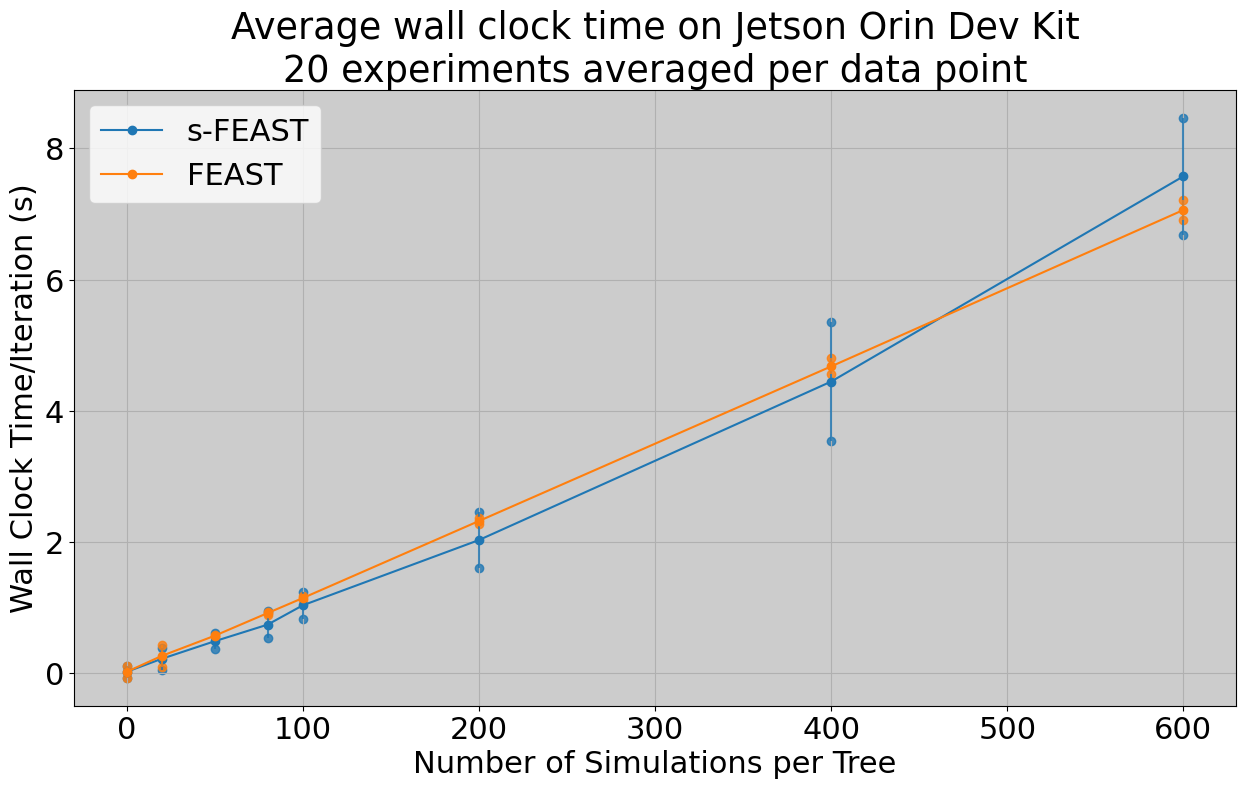

In [28]:
#Data location defaults to failurePy/SavedData, you can specify a different location with the optional argument: savedDataDirPath
plotMultipleWallClockTimes(["figureS1/safetyOnJetsonOrin","figureS1/safetyOffJetsonOrin"],["SFEAST"],labels=["s-FEAST","FEAST"],sigmaFlag=True)


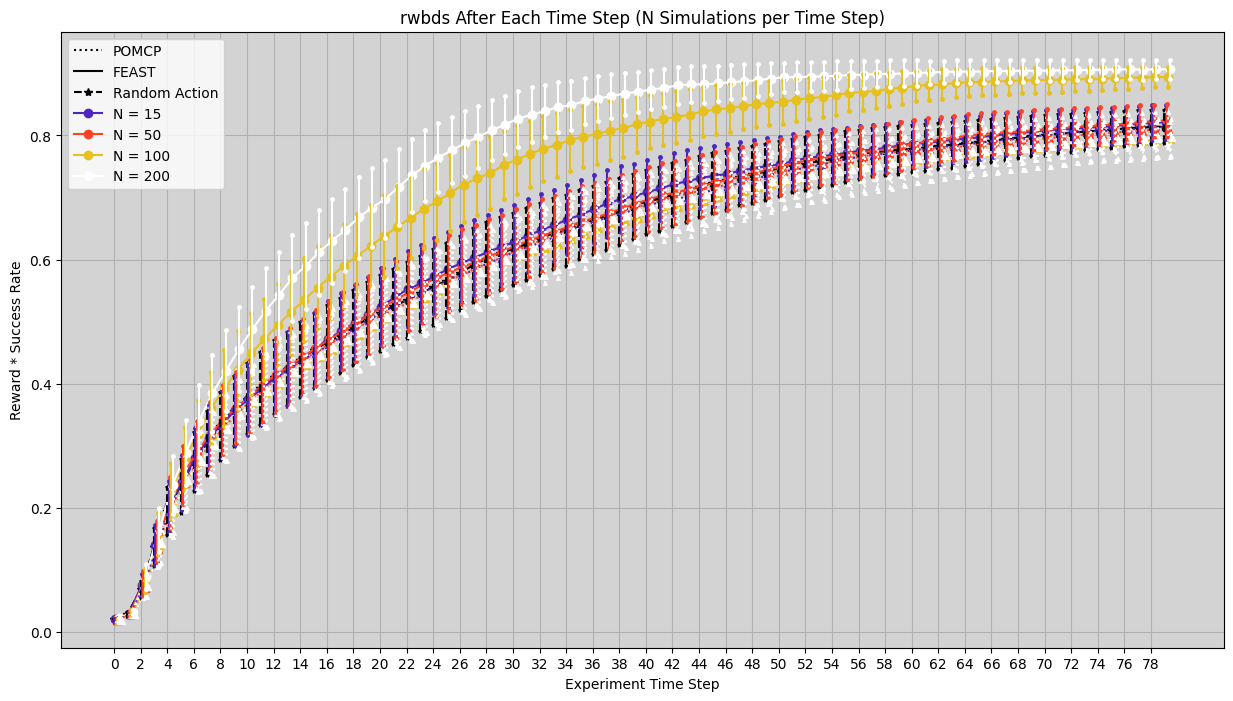

In [14]:
#Note that some post processing was done using Affinity Designer when creating the composite image to improve readability, but no data was changed.
#plotData1SigmaRewards("DoubleIntegrator2DHighNoise","SET_AS_ABS_PATH_TO_failurePy/SavedData/figureS2",["FEAST","POMCP"],numTrialsPerPoint=1000,successRateAdjust=True,tSteps=20)
plotData1SigmaRewards("DoubleIntegrator2DHighNoiseExtended","SET_AS_ABS_PATH_TO_failurePy/SavedData",["FEAST","POMCP"],numTrialsPerPoint=1000,successRateAdjust=True,tSteps=80)


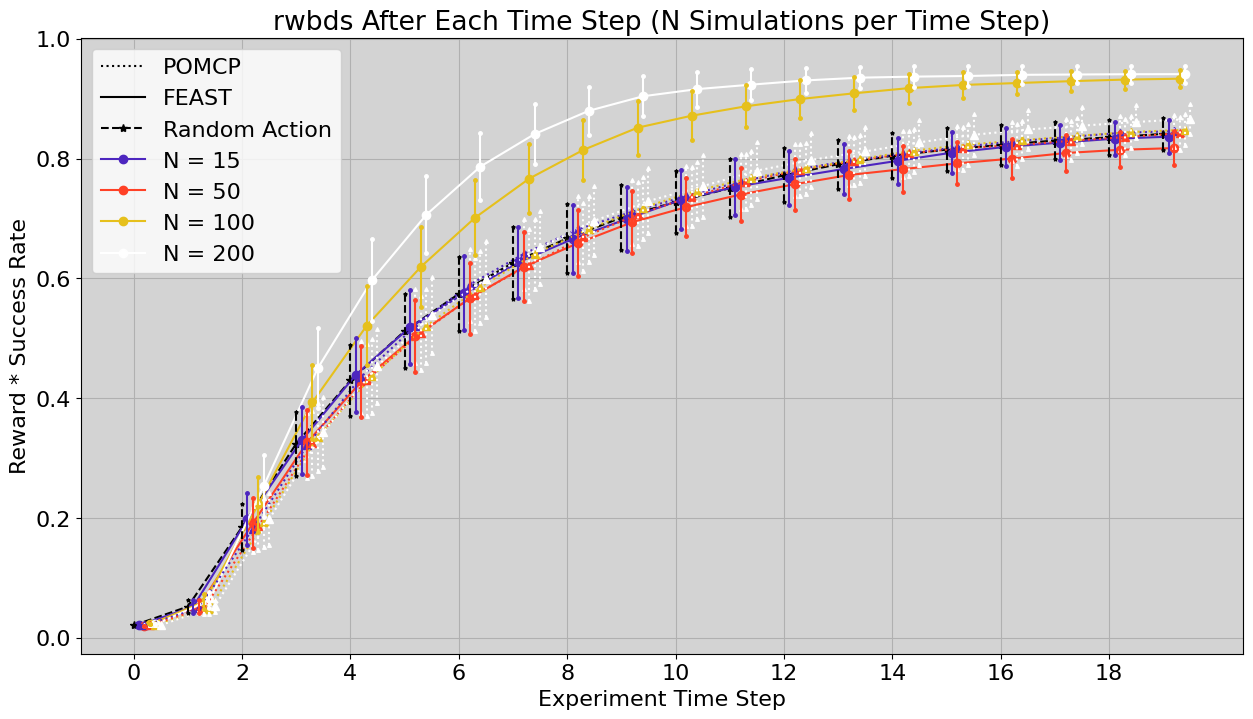

In [27]:
#Note that some post processing was done using Affinity Designer when creating the composite image to improve readability, but no data was changed.
plotData1SigmaRewards("DoubleIntegrator2DLowNoise","SET_AS_ABS_PATH_TO_failurePy/SavedData/figureS2",["FEAST","POMCP"],numTrialsPerPoint=1000,successRateAdjust=True)

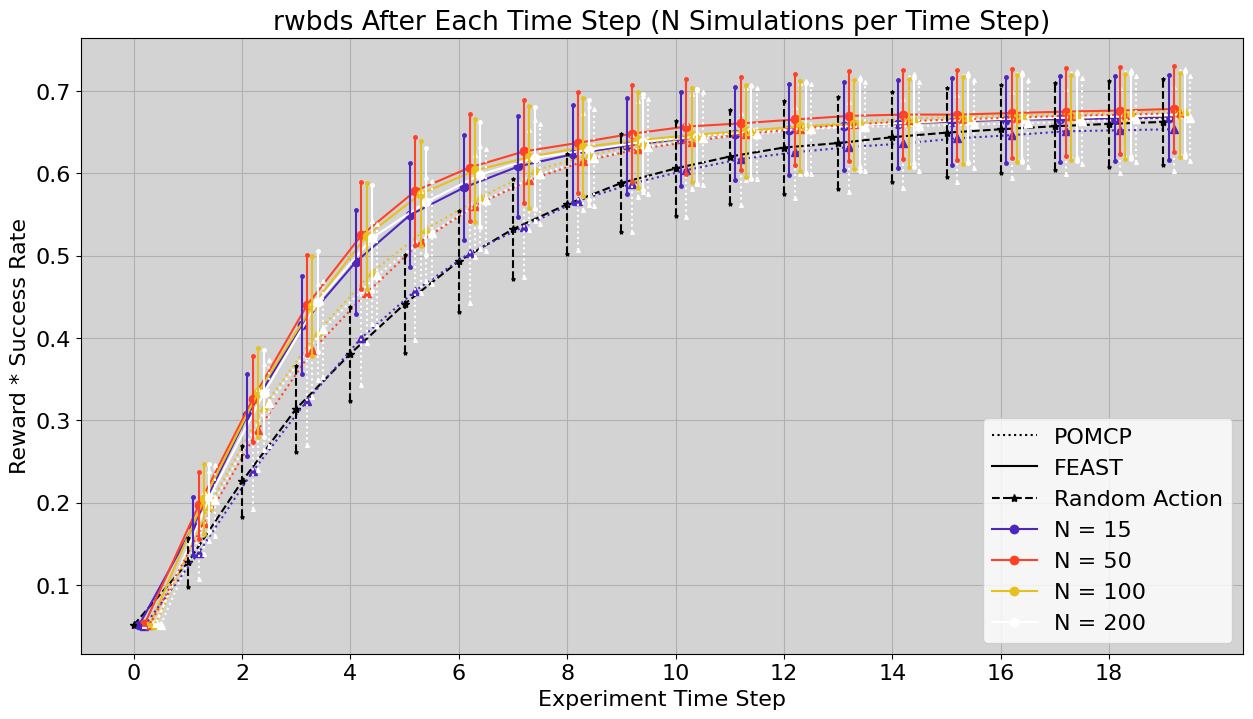

In [28]:
#Note that some post processing was done using Affinity Designer when creating the composite image to improve readability, but no data was changed.
plotData1SigmaRewards("SingleIntegrator1DHighNoise","SET_AS_ABS_PATH_TO_failurePy/SavedData/SavedData/figureS2",["FEAST","POMCP"],numTrialsPerPoint=1000,successRateAdjust=True)

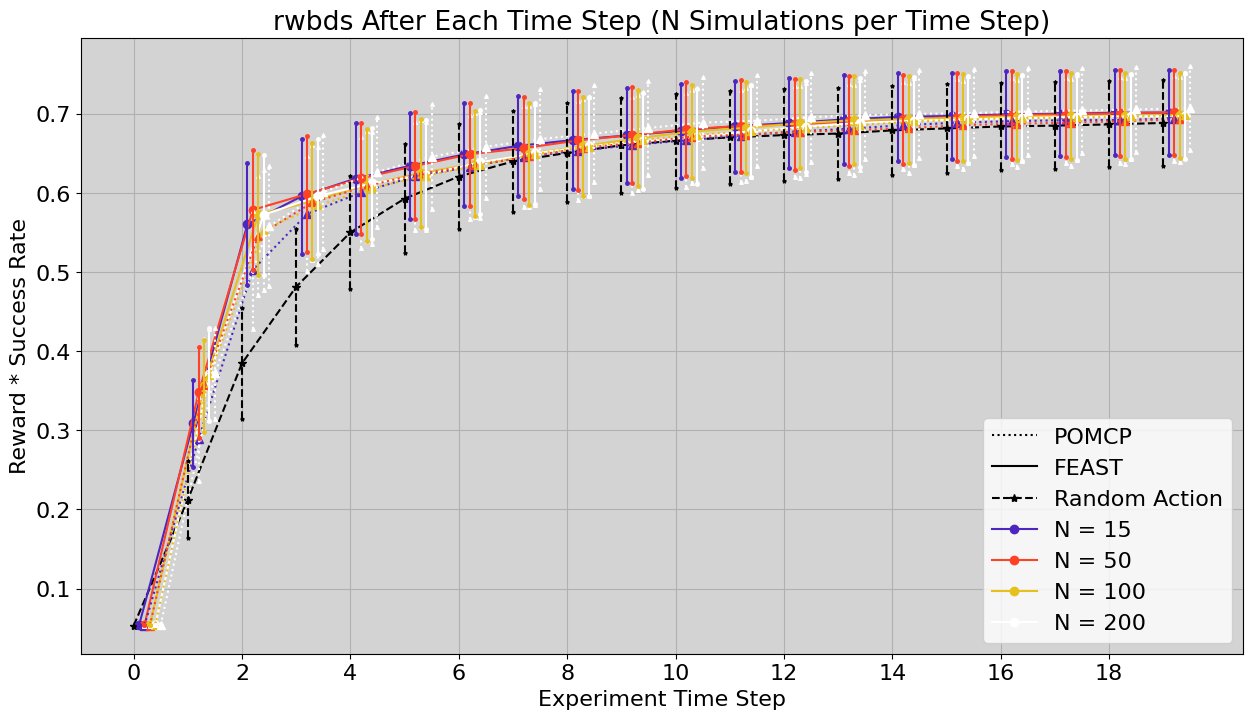

In [29]:
#Note that some post processing was done using Affinity Designer when creating the composite image to improve readability, but no data was changed.
plotData1SigmaRewards("SingleIntegrator1DLowNoise","SET_AS_ABS_PATH_TO_failurePy/SavedData/figureS2",["FEAST","POMCP"],numTrialsPerPoint=1000,successRateAdjust=True)